#Bounding Box Simulations

In [1]:
import math
import torch
import matplotlib.pyplot as plt

In [2]:
#Params
class params:
  def __init__(self):
    self.eta = 1 #Learning rate
    self.num_iters = 100
    self.ground_truth = [1., 1., 5., 4.] #Aspect Ratio 4:3
    self.start_point = [2., 4., 7., 10.]

In [3]:
def bbox_iou(box1, box2, xywh=False, GIoU=False, DIoU=False, CIoU=False, m2IoU = False, alpha = 0.25, eps=1e-7):
    """
    Calculate Intersection over Union (IoU) of box1(1, 4) to box2(n, 4).

    Args:
        box1 (torch.Tensor): A tensor representing a single bounding box with shape (1, 4).
        box2 (torch.Tensor): A tensor representing n bounding boxes with shape (n, 4).
        xywh (bool, optional): If True, input boxes are in (x, y, w, h) format. If False, input boxes are in
                               (x1, y1, x2, y2) format
        GIoU (bool, optional): If True, calculate Generalized IoU. Defaults to False.
        DIoU (bool, optional): If True, calculate Distance IoU. Defaults to False.
        CIoU (bool, optional): If True, calculate Complete IoU. Defaults to False.
        m2IoU (bool, optional): If True, calculate min max IoU. Defaults to False.
        eps (float, optional): A small value to avoid division by zero. Defaults to 1e-7.

    Returns:
        (torch.Tensor): IoU, GIoU, DIoU, CIoU or m2IoU values depending on the specified flags.
    """

    # Get the coordinates of bounding boxes

    if xywh:  # transform from xywh to xyxy
        (x1, y1, w1, h1), (x2, y2, w2, h2) = box1.chunk(4, -1), box2.chunk(4, -1)
        w1_, h1_, w2_, h2_ = w1 / 2, h1 / 2, w2 / 2, h2 / 2
        b1_x1, b1_x2, b1_y1, b1_y2 = x1 - w1_, x1 + w1_, y1 - h1_, y1 + h1_
        b2_x1, b2_x2, b2_y1, b2_y2 = x2 - w2_, x2 + w2_, y2 - h2_, y2 + h2_
    else:  # x1, y1, x2, y2 = box1
        b1_x1, b1_y1, b1_x2, b1_y2 = box1.chunk(4, -1)
        b2_x1, b2_y1, b2_x2, b2_y2 = box2.chunk(4, -1)
        w1, h1 = b1_x2 - b1_x1, b1_y2 - b1_y1 + eps
        w2, h2 = b2_x2 - b2_x1, b2_y2 - b2_y1 + eps

    # Intersection area
    inter = (b1_x2.minimum(b2_x2) - b1_x1.maximum(b2_x1)).clamp_(0) * \
            (b1_y2.minimum(b2_y2) - b1_y1.maximum(b2_y1)).clamp_(0)

    # Union Area
    union = w1 * h1 + w2 * h2 - inter + eps

    # IoU
    iou = inter / union

    if CIoU or DIoU or GIoU or m2IoU:
        cw = b1_x2.maximum(b2_x2) - b1_x1.minimum(b2_x1)  # convex (smallest enclosing box) width
        ch = b1_y2.maximum(b2_y2) - b1_y1.minimum(b2_y1)  # convex height

        if CIoU or DIoU or m2IoU:  # Distance or Complete IoU https://arxiv.org/abs/1911.08287v1
            c2 = cw ** 2 + ch ** 2 + eps  # convex diagonal squared
            rho2 = ((b2_x1 + b2_x2 - b1_x1 - b1_x2) ** 2 + (b2_y1 + b2_y2 - b1_y1 - b1_y2) ** 2) / 4  # center dist ** 2

            if m2IoU:
              d1_sqrd = (b1_x1 - b2_x1)**2 + (b1_y1 - b2_y1)**2
              d2_sqrd = (b1_x2 - b2_x2)**2 + (b1_y2 - b2_y2)**2
              d_min = d1_sqrd.minimum(d2_sqrd)
              d_max = d1_sqrd.maximum(d2_sqrd)

              m2_coeff = (alpha*d_min + (1-alpha)*d_max)/c2
              return 1 - iou + m2_coeff # m2IOU

            if CIoU:  # https://github.com/Zzh-tju/DIoU-SSD-pytorch/blob/master/utils/box/box_utils.py#L47
                v = (4 / math.pi ** 2) * (torch.atan(w2 / h2) - torch.atan(w1 / h1)).pow(2)
                with torch.no_grad():
                    alpha = v / (v - iou + (1 + eps))
                return 1 - iou + (rho2 / c2 + v * alpha)  # CIoU
            return 1 - iou + rho2 / c2  # DIoU
        c_area = cw * ch + eps  # convex area
        return 1 - iou + (c_area - union) / c_area  # GIoU https://arxiv.org/pdf/1902.09630.pdf
    return 1 - iou  # IoU

In [4]:
def derivative_IoU(box1, box2, xywh=False, GIoU=False, DIoU=False, CIoU=False, m2IoU = False, alpha = 0.25, eps=1e-7):
  dx = .1
  dy = 4/3 * dx #Aspect Ratio of the ground truth
  change = box2.detach().clone()

  #x1
  change[0] += dx
  dL_dx1 = (bbox_iou(box1, change, xywh, GIoU, DIoU, CIoU, m2IoU, alpha) - bbox_iou(box1, box2, xywh, GIoU, DIoU, CIoU, m2IoU, alpha))/dx
  change[0] -= dx

  #y1
  change[1] += dy
  dL_dy1 = (bbox_iou(box1, change, xywh, GIoU, DIoU, CIoU, m2IoU, alpha) - bbox_iou(box1, box2, xywh, GIoU, DIoU, CIoU, m2IoU, alpha))/dx
  change[1] -= dy

  #x2
  change[2] += dx
  dL_dx2 = (bbox_iou(box1, change, xywh, GIoU, DIoU, CIoU, m2IoU, alpha) - bbox_iou(box1, box2, xywh, GIoU, DIoU, CIoU, m2IoU, alpha))/dx
  change[2] -= dx

  #y2
  change[3] += dy
  dL_dy2 = (bbox_iou(box1, change, xywh, GIoU, DIoU, CIoU, m2IoU, alpha) - bbox_iou(box1, box2, xywh, GIoU, DIoU, CIoU, m2IoU, alpha))/dx
  change[3] -= dy

  return torch.tensor([dL_dx1, dL_dy1, dL_dx2, dL_dy2]).float()


In [5]:
def iou(box1, box2, xywh=False, eps=1e-7):

    # Get the coordinates of bounding boxes
    if xywh:  # transform from xywh to xyxy
        (x1, y1, w1, h1), (x2, y2, w2, h2) = box1.chunk(4, -1), box2.chunk(4, -1)
        w1_, h1_, w2_, h2_ = w1 / 2, h1 / 2, w2 / 2, h2 / 2
        b1_x1, b1_x2, b1_y1, b1_y2 = x1 - w1_, x1 + w1_, y1 - h1_, y1 + h1_
        b2_x1, b2_x2, b2_y1, b2_y2 = x2 - w2_, x2 + w2_, y2 - h2_, y2 + h2_
    else:  # x1, y1, x2, y2 = box1
        b1_x1, b1_y1, b1_x2, b1_y2 = box1.chunk(4, -1)
        b2_x1, b2_y1, b2_x2, b2_y2 = box2.chunk(4, -1)
        w1, h1 = b1_x2 - b1_x1, b1_y2 - b1_y1 + eps
        w2, h2 = b2_x2 - b2_x1, b2_y2 - b2_y1 + eps

    # Intersection area
    inter = (b1_x2.minimum(b2_x2) - b1_x1.maximum(b2_x1)).clamp_(0) * \
            (b1_y2.minimum(b2_y2) - b1_y1.maximum(b2_y1)).clamp_(0)

    # Union Area
    union = w1 * h1 + w2 * h2 - inter + eps

    # IoU
    iou = inter / union
    return iou

In [6]:
def trajectory(box1, box2, num_iters, eta, GIoU=False, DIoU=False, CIoU=False, m2IoU = False, alpha = 0.25):
  IOU = []
  for iterations in range(1, num_iters+1, 1):
    iou_val = iou(box1, box2)
    IOU.append(iou_val)
    dL_dC = derivative_IoU(box1, box2, False, GIoU, DIoU, CIoU, m2IoU, alpha)

    if iterations < 50 :
      box2 -= eta * dL_dC

    elif iterations > 50 and iterations < 120:
      box2 -= (eta/5) * dL_dC

    elif iterations > 120 :
      box2 -= (eta/10) * dL_dC

  return IOU

In [9]:
Params = params()
loss_funcs = ['IoU', 'GIoU', 'DIoU', 'CIoU', 'm2IoU']
trajectory_dict = {}

In [11]:
for loss in loss_funcs:
  b1 = torch.tensor(Params.ground_truth).float()
  b2 = torch.tensor(Params.start_point).float()
  if loss == 'IoU':
    trajectory_dict['IoU'] = trajectory(b1, b2, Params.num_iters, Params.eta)

  elif loss == 'GIoU':
    trajectory_dict['GIoU'] = trajectory(b1, b2, Params.num_iters, Params.eta, GIoU = True)

  elif loss == 'DIoU':
    trajectory_dict['DIoU'] = trajectory(b1, b2, Params.num_iters, Params.eta, DIoU = True)

  elif loss == 'CIoU':
    trajectory_dict['CIoU'] = trajectory(b1, b2, Params.num_iters, Params.eta, CIoU = True)

  elif loss == 'm2IoU':
    trajectory_dict['m2IoU'] = trajectory(b1, b2, Params.num_iters, Params.eta, m2IoU = True)


/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


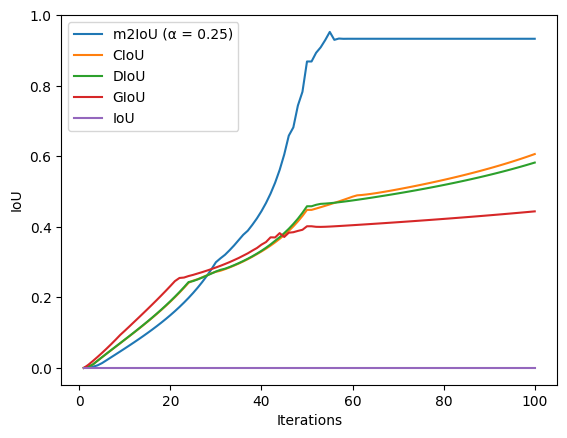

In [12]:
#iters
iters = list(range(1, Params.num_iters+1, 1))

# Create a figure and axis
fig, ax = plt.subplots()

# Plot
ax.plot(iters, trajectory_dict['m2IoU'], label='m2IoU (\u03B1 = 0.25)')
ax.plot(iters, trajectory_dict['CIoU'], label='CIoU')
ax.plot(iters, trajectory_dict['DIoU'], label='DIoU')
ax.plot(iters, trajectory_dict['GIoU'], label='GIoU')
ax.plot(iters, trajectory_dict['IoU'], label='IoU')


# Add labels and a legend
ax.set_xlabel('Iterations')
ax.set_ylabel('IoU')
ax.legend()

# Show the plot
plt.show()


Box Plots

In [7]:
#Case 1, concentric boxes
b1 = torch.tensor([0, 0, 10, 10])
b2_a = torch.tensor([2.5, 2.5, 7.5, 7.5])

#Case 2, one vertex coinciding
b2_b = torch.tensor([5, 5, 10, 10])

#Case 3 box2 lying outside box1
b2_c = torch.tensor([7.5, 7.5, 12.5, 12.5])
loss_funcs = ['IoU', 'GIoU', 'DIoU', 'CIoU', 'm2IoU']

In [15]:
loss_dict_1 = {}
for loss in loss_funcs:
  if loss == 'IoU':
    b2_a = torch.tensor([2.5, 2.5, 7.5, 7.5])
    loss_dict_1 ['IoU'] = bbox_iou(b1, b2_a)

  elif loss == 'GIoU':
    loss_dict_1 ['GIoU'] = bbox_iou(b1, b2_a, GIoU=True)

  elif loss == 'DIoU':
    loss_dict_1 ['DIoU'] = bbox_iou(b1, b2_a, DIoU=True)

  elif loss == 'CIoU':
    loss_dict_1 ['CIoU'] = bbox_iou(b1, b2_a, CIoU=True)

  elif loss == 'm2IoU':
    loss_dict_1 ['m2IoU'] = bbox_iou(b1, b2_a, m2IoU=True)

In [16]:
print(loss_dict_1)

{'IoU': tensor([0.7500]), 'GIoU': tensor([0.7500]), 'DIoU': tensor([0.7500]), 'CIoU': tensor([0.7500]), 'm2IoU': tensor([0.8125])}


In [17]:
loss_dict_1 = {}
for loss in loss_funcs:
  if loss == 'IoU':
    b2_a = torch.tensor([5, 5, 10, 10])
    loss_dict_1 ['IoU'] = bbox_iou(b1, b2_a)

  elif loss == 'GIoU':
    loss_dict_1 ['GIoU'] = bbox_iou(b1, b2_a, GIoU=True)

  elif loss == 'DIoU':
    loss_dict_1 ['DIoU'] = bbox_iou(b1, b2_a, DIoU=True)

  elif loss == 'CIoU':
    loss_dict_1 ['CIoU'] = bbox_iou(b1, b2_a, CIoU=True)

  elif loss == 'm2IoU':
    loss_dict_1 ['m2IoU'] = bbox_iou(b1, b2_a, m2IoU=True)

In [18]:
print(loss_dict_1)

{'IoU': tensor([0.7500]), 'GIoU': tensor([0.7500]), 'DIoU': tensor([0.8125]), 'CIoU': tensor([0.8125]), 'm2IoU': tensor([0.9375])}


In [23]:
loss_dict_1 = {}
for loss in loss_funcs:
  if loss == 'IoU':
    b2_a = torch.tensor([7.5, 7.5, 12.5, 12.5])
    loss_dict_1 ['IoU'] = bbox_iou(b1, b2_a)

  elif loss == 'GIoU':
    loss_dict_1 ['GIoU'] = bbox_iou(b1, b2_a, GIoU=True)

  elif loss == 'DIoU':
    loss_dict_1 ['DIoU'] = bbox_iou(b1, b2_a, DIoU=True)

  elif loss == 'CIoU':
    loss_dict_1 ['CIoU'] = bbox_iou(b1, b2_a, CIoU=True)

  elif loss == 'm2IoU':
    loss_dict_1 ['m2IoU'] = bbox_iou(b1, b2_a, m2IoU=True)

In [24]:
print(loss_dict_1)

{'IoU': tensor([0.9474]), 'GIoU': tensor([1.1874]), 'DIoU': tensor([1.1074]), 'CIoU': tensor([1.1074]), 'm2IoU': tensor([1.2274])}
